In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Callable, List, Dict, Tuple
import matplotlib.pyplot as plt

#### Loading Data
We've provided a training set and a validation set.

In [2]:
with open("train.pkl", "rb") as f:
    train_dataset = pickle.load(f)

with open("validation.pkl", "rb") as f:
    val_dataset = pickle.load(f)

#### Model Evaluation
To evaluate the performance of a model, we compare the forecasted OAS of the model to the actual OAS of the trade. We clip the error to be between -10 and 10.

In [3]:
def evaluate_model(model: Callable[[pd.DataFrame], float], dataset: List[Dict]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Model should be a function that takes a dataframe of historical trades and returns a predicted OAS. 
    """
    errors = []
    for i in tqdm(range(len(dataset))):
        observation = dataset[i]
        prev_trades = observation["prev_trades"]
        if len(prev_trades) == 0:
            continue
        predicted_oas = model(prev_trades)
        errors.append(
            {
                "id": i,
                "bias": np.clip(observation["oas"] - predicted_oas, -25, 25),
                "error": np.clip(abs(observation["oas"] - predicted_oas), 0, 25)
            }
        )
    errors_df = pd.DataFrame(errors).set_index("id")
    return errors_df.describe(), errors_df

#### Example model: latest trade
Here is an example model that simply returns the OAS of the most recent trade.

In [4]:
def last_dealer_trade_model(prev_trades: pd.DataFrame) -> float:
    filt = prev_trades[prev_trades['trade_type'] == 'dealer_dealer']
    if len(filt) > 0:
        return filt.iloc[-1]['oas']
    return prev_trades.iloc[-1]["oas"]

def mean_dealer_trade_model(prev_trades: pd.DataFrame) -> float:
    filt = prev_trades[prev_trades['trade_type'] == 'dealer_dealer']
    if len(filt) > 0:
        return filt['oas'].mean()
    
    return prev_trades.iloc[-1]["oas"]



In [5]:
def last_trade_model(prev_trades: pd.DataFrame) -> float:
    return prev_trades.iloc[-1]["oas"]

In [6]:
evaluate_model(last_trade_model, val_dataset)[0]

100%|██████████| 52062/52062 [00:05<00:00, 10013.49it/s]


,bias,error
count,52062.000000,52062.000000
mean,0.575663,3.818279
std,6.486537,5.275133
min,-25.000000,0.000000
25%,-1.591775,0.802200
50%,0.241350,1.923350
75%,2.242475,4.259400
max,25.000000,25.000000


In [7]:
evaluate_model(last_dealer_trade_model, val_dataset)[0]

100%|██████████| 52062/52062 [00:09<00:00, 5409.46it/s]


,bias,error
count,52062.000000,52062.000000
mean,0.085910,3.679828
std,6.117173,4.887309
min,-25.000000,0.000000
25%,-1.840600,0.837725
50%,0.135600,1.985950
75%,2.112175,4.298075
max,25.000000,25.000000


In [8]:
evaluate_model(mean_dealer_trade_model, val_dataset)[0]

100%|██████████| 52062/52062 [00:08<00:00, 6475.72it/s]


,bias,error
count,52062.000000,52062.000000
mean,-0.267138,4.186084
std,6.816734,5.386612
min,-25.000000,0.000000
25%,-2.398700,0.964684
50%,-0.011836,2.266860
75%,2.150884,4.899404
max,25.000000,25.000000


#### Your Model Here

# Scratch

In [9]:
def check_imbal(dataset: List[Dict]) -> List[Dict]:

    trades = []
    
    for i in tqdm(range(len(dataset))):
        observation = dataset[i]
        prev_trades = observation["prev_trades"]
        if len(prev_trades) == 0:
            continue
    
        trades.append({
            'dealer_buys': len(prev_trades[prev_trades['trade_type'] == 'dealer_buy']),
            'dealer_sells': len(prev_trades[prev_trades['trade_type'] == 'dealer_sell']),
            'dealer_dealer': len(prev_trades[prev_trades['trade_type'] == 'dealer_dealer']),
        })
    return trades

In [10]:
imbal = pd.DataFrame(check_imbal(train_dataset))

100%|██████████| 156186/156186 [00:56<00:00, 2772.08it/s]


In [11]:
def reformat_data(dataset: List[Dict]) -> List[Dict]:

    ret_data = []
    
    for i in tqdm(range(len(dataset))):
        observation = dataset[i]
        prev_trades = observation["prev_trades"]
        if len(prev_trades) == 0:
            continue

        row_data = {}
        row_data['target_oas'] = observation['oas']
        
        for ix, row in prev_trades.reset_index().iterrows():
            row_data[f'trade_type_{ix}'] = row['trade_type']
            row_data[f'quantity_{ix}'] = row['quantity']
            row_data[f'oas_{ix}'] = row['oas']
            row_data[f'ts_diff_hrs_{ix}'] = row['ts_diff_hrs']
            
        ret_data.append(row_data)
        
    return ret_data

In [12]:
train_reformat = reformat_data(train_dataset)

100%|██████████| 156186/156186 [01:20<00:00, 1932.56it/s]


In [13]:
df = pd.DataFrame(train_reformat)

In [14]:
df_test = df.copy()

# Test stuff

In [16]:
df_test

,target_oas,trade_type_0,quantity_0,oas_0,ts_diff_hrs_0,trade_type_1,quantity_1,oas_1,ts_diff_hrs_1,trade_type_2,...,ts_diff_hrs_22,trade_type_23,quantity_23,oas_23,ts_diff_hrs_23,trade_type_24,quantity_24,oas_24,ts_diff_hrs_24,trade_type_int_0
0,143.6568,dealer_sell,1000000.0,159.9200,866.390833,dealer_sell,1000000.0,159.9200,866.390833,dealer_sell,...,114.960000,dealer_buy,1000000.0,136.6920,114.959444,dealer_buy,300000.0,152.3301,26.343611,0
1,209.4560,dealer_buy,600000.0,155.3955,1036.245556,dealer_buy,200000.0,149.5522,1002.218333,dealer_sell,...,235.618889,dealer_buy,1000000.0,167.1077,43.621667,dealer_sell,1000000.0,137.5897,19.614444,0
2,207.8739,dealer_buy,250000.0,124.6790,691.526111,dealer_buy,300000.0,124.6828,643.532222,dealer_sell,...,67.524444,dealer_sell,200000.0,132.6488,19.523611,dealer_sell,304000.0,204.2371,19.523333,0
3,249.6334,dealer_sell,1000000.0,137.5897,837.848056,dealer_dealer,1000000.0,209.4560,818.233611,dealer_buy,...,51.726944,dealer_sell,1000000.0,128.6058,50.231389,dealer_buy,1000000.0,171.6017,50.231389,0
4,227.6924,dealer_buy,1000000.0,209.4560,1079.640556,dealer_sell,1000000.0,209.4560,1079.610278,dealer_sell,...,311.638333,dealer_dealer,1000000.0,249.6334,261.406944,dealer_buy,1000000.0,249.6334,261.406944,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156181,169.1681,dealer_buy,252000.0,175.9907,312.156111,dealer_dealer,15000.0,175.0418,241.383333,dealer_buy,...,1.492222,dealer_sell,5000000.0,166.7699,1.291944,dealer_buy,20000.0,169.5320,1.207222,0
156182,167.5753,dealer_sell,2000.0,174.4407,241.011667,dealer_dealer,2000.0,175.1334,241.011667,dealer_dealer,...,3.222500,dealer_dealer,1000000.0,169.1681,3.222500,dealer_buy,341000.0,167.5433,0.995556,0
156183,170.4838,dealer_sell,60000.0,165.4830,258.279722,dealer_buy,60000.0,165.9750,258.279444,dealer_sell,...,68.346944,dealer_buy,209000.0,168.5852,68.260556,dealer_dealer,209000.0,168.3040,68.260556,0
156184,165.4786,dealer_dealer,30000.0,165.6199,258.524167,dealer_buy,1350000.0,169.1103,241.038333,dealer_sell,...,24.895556,dealer_dealer,15000.0,162.5864,20.827778,dealer_sell,15000.0,162.5864,20.827778,1


In [232]:
for i in range(25):
    df_test[f'naive_error_{i}'] = np.clip(abs(df_test[f'oas_{i}'] - df_test[f'target_oas']), 0, 25)

df_test['last_5_oas'] = (5 * df_test['oas_24'] + 4 * df_test['oas_23'] + 3 * df_test['oas_22'] + 2 * df_test['oas_21'] + df_test['oas_20']) / 15

df_test['last_5_oas_ewm'] = (16 * df_test['oas_24'] + 8 * df_test['oas_23'] + 4 * df_test['oas_22'] + 2 * df_test['oas_21'] + df_test['oas_20']) / 31


In [225]:
def test_lookbacks_naive_err(df: pd.DataFrame) -> List[Dict]:
    ret = {}
    for i in range(25):
        curr = 0
        div = 0
        for j in range(i + 1):
            curr += (24 - j) * df[f'oas_{j}']
            div += (24 - j)
        
        ret[i] = np.clip(abs(curr / div - df['target_oas']), 0, 25)
    
    return ret
            

In [226]:
lookback_naive = test_lookbacks_naive_err(df_test)

In [231]:
pd.DataFrame(lookback_naive).describe(percentiles = [0.01, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95]).T

,count,mean,std,min,1%,5%,15%,30%,50%,70%,85%,95%,max
0,156186.0,6.368989,7.205838,0.0,0.045185,0.267900,0.830950,1.766050,3.467650,6.662900,13.411475,25.000000,25.0
1,155949.0,6.291452,7.060147,0.0,0.045790,0.264972,0.829517,1.759996,3.463983,6.703210,13.067924,25.000000,25.0
2,155686.0,6.191521,6.964976,0.0,0.048685,0.266495,0.814599,1.742249,3.440898,6.616596,12.638139,25.000000,25.0
3,155479.0,6.098744,6.887920,0.0,0.046005,0.262672,0.807684,1.728882,3.417021,6.490300,12.279863,25.000000,25.0
4,155277.0,6.011439,6.831100,0.0,0.045824,0.258317,0.804497,1.718432,3.366000,6.334966,12.013914,25.000000,25.0
5,155064.0,5.932941,6.779377,0.0,0.047362,0.260200,0.797922,1.695581,3.317514,6.215297,11.795094,25.000000,25.0
6,154889.0,5.861588,6.737823,0.0,0.047333,0.256007,0.788436,1.670947,3.270341,6.104184,11.585604,25.000000,25.0
7,154715.0,5.796682,6.699145,0.0,0.045842,0.251327,0.778743,1.651173,3.213928,6.013356,11.395959,25.000000,25.0
8,154532.0,5.735001,6.661690,0.0,0.046188,0.248880,0.769276,1.632692,3.173298,5.922268,11.227243,25.000000,25.0
9,154384.0,5.676637,6.625192,0.0,0.044063,0.245234,0.759862,1.615366,3.136520,5.842353,11.072306,25.000000,25.0


In [233]:
df_test['naive_error_last_test'] = np.clip(abs(
                                            (2 * df_test['oas_24'] + 1 * df_test['oas_23']) / 3
                                               - df_test[f'target_oas']), 0, 25)

In [256]:
cols = [col for col in df_test.columns if col.startswith('naive_error')]
df_test[cols].describe(percentiles = [0.01, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95]).T

,count,mean,std,min,1%,5%,15%,30%,50%,70%,85%,95%,max
naive_error_0,156186.0,6.368989,7.205838,0.0,0.045185,0.267900,0.830950,1.766050,3.467650,6.662900,13.411475,25.000000,25.0
naive_error_1,155949.0,6.304177,7.157816,0.0,0.044200,0.262800,0.825100,1.754240,3.421400,6.561060,13.130440,25.000000,25.0
naive_error_2,155686.0,6.233978,7.121554,0.0,0.043000,0.260500,0.805600,1.731200,3.366600,6.471100,12.978925,25.000000,25.0
naive_error_3,155479.0,6.171321,7.094785,0.0,0.041700,0.249900,0.786770,1.697700,3.320500,6.386680,12.786090,25.000000,25.0
naive_error_4,155277.0,6.093959,7.052629,0.0,0.043700,0.252180,0.780600,1.674000,3.264900,6.249920,12.533880,25.000000,25.0
naive_error_5,155064.0,6.020312,7.008872,0.0,0.043463,0.246900,0.768800,1.649190,3.210300,6.146400,12.295220,25.000000,25.0
naive_error_6,154889.0,5.969319,6.990769,0.0,0.041388,0.245040,0.764200,1.633640,3.176500,6.045500,12.173860,25.000000,25.0
naive_error_7,154715.0,5.877811,6.938140,0.0,0.039800,0.237170,0.748600,1.595500,3.092900,5.936380,11.978700,25.000000,25.0
naive_error_8,154532.0,5.816617,6.898553,0.0,0.041100,0.239500,0.745600,1.574700,3.052650,5.851250,11.763935,25.000000,25.0
naive_error_9,154384.0,5.742720,6.857767,0.0,0.039300,0.234200,0.732700,1.549400,2.998800,5.743030,11.558600,25.000000,25.0


In [168]:
#feature_cols = [col for col in df_test.columns if col in ['oas_20', 'oas_21', 'oas_22', 'oas_23', 'oas_24']]
feature_cols = [col for col in df_test.columns if col in ['oas_23', 'oas_24']]

In [102]:
def get_last_dealer_data(dataset: List[Dict]) -> List[Dict]:

    ret_data = []
    
    for i in tqdm(range(len(dataset))):
        observation = dataset[i]
        prev_trades = observation["prev_trades"]
        if len(prev_trades) == 0:
            continue

        row_data = {}
        
        for ix, row in prev_trades.reset_index().iterrows():
            if row['trade_type'] == 'dealer_dealer':
                row_data['trade_type'] = row['trade_type']
                row_data['ts_diff_hrs'] = row['ts_diff_hrs']
                row_data['quantity'] = row['quantity']
                row_data['oas'] = row['oas']
        
        if row_data:
            row_data['target_oas'] = observation['oas']
   
        ret_data.append(row_data)
        
    return ret_data

In [18]:
df_dealer_last = pd.DataFrame(get_last_dealer_data(train_dataset))

100%|██████████| 156186/156186 [01:10<00:00, 2206.65it/s]


In [19]:
df_dealer_last

,trade_type,ts_diff_hrs,quantity,oas,target_oas
0,dealer_dealer,358.546944,400000.0,110.7116,143.6568
1,dealer_dealer,240.662778,1000000.0,143.6568,209.4560
2,dealer_dealer,143.908611,1000000.0,209.4560,207.8739
3,dealer_dealer,146.966111,250000.0,217.7949,249.6334
4,dealer_dealer,261.406944,1000000.0,249.6334,227.6924
...,...,...,...,...,...
156181,dealer_dealer,166.379444,200000.0,167.9457,169.1681
156182,dealer_dealer,3.222500,1000000.0,169.1681,167.5753
156183,dealer_dealer,68.260556,209000.0,168.3040,170.4838
156184,dealer_dealer,20.827778,15000.0,162.5864,165.4786


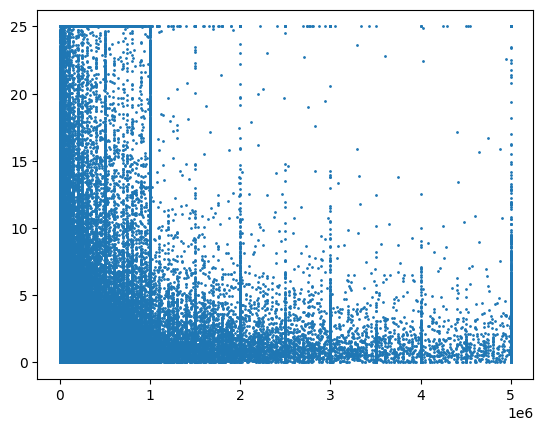

In [20]:
plt.scatter(df_dealer_last['quantity'], np.clip(abs(df_dealer_last['target_oas'] - df_dealer_last['oas']), 0, 25), s = 1)

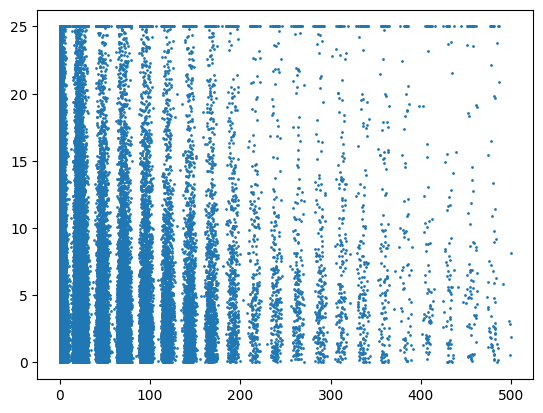

In [23]:
plt.scatter(df_dealer_last[df_dealer_last['ts_diff_hrs'] < 500]['ts_diff_hrs'], np.clip(abs(df_dealer_last[df_dealer_last['ts_diff_hrs'] < 500]['target_oas'] - df_dealer_last[df_dealer_last['ts_diff_hrs'] < 500]['oas']), 0, 25), s = 1)

In [24]:
def get_last_trade(dataset: List[Dict]) -> List[Dict]:

    ret_data = []
    
    for i in tqdm(range(len(dataset))):
        observation = dataset[i]
        prev_trades = observation["prev_trades"]
        if len(prev_trades) == 0:
            continue

        row_data = {}

        last = prev_trades.iloc[-1]
        row_data['trade_type'] = last['trade_type']
        row_data['ts_diff_hrs'] = last['ts_diff_hrs']
        row_data['quantity'] = last['quantity']
        row_data['oas'] = last['oas']     
        row_data['target_oas'] = observation['oas']


        ret_data.append(row_data)
        
    return ret_data

In [25]:
df_trade_last = pd.DataFrame(get_last_trade(train_dataset))

100%|██████████| 156186/156186 [00:06<00:00, 24035.03it/s]


In [29]:
df_trade_last['error'] = abs(df_trade_last['oas'] - df_trade_last['target_oas'])
df_trade_last['error'] = np.clip(df_trade_last['error'], 0 ,25)

df_trade_last['bias'] = df_trade_last['oas'] - df_trade_last['target_oas']
df_trade_last['bias'] = np.clip(df_trade_last['bias'], -25 ,25)

In [26]:
df_trade_last

,trade_type,ts_diff_hrs,quantity,oas,target_oas
0,dealer_buy,26.343611,300000.0,152.3301,143.6568
1,dealer_sell,19.614444,1000000.0,137.5897,209.4560
2,dealer_sell,19.523333,304000.0,204.2371,207.8739
3,dealer_buy,50.231389,1000000.0,171.6017,249.6334
4,dealer_buy,261.406944,1000000.0,249.6334,227.6924
...,...,...,...,...,...
156181,dealer_buy,1.207222,20000.0,169.5320,169.1681
156182,dealer_buy,0.995556,341000.0,167.5433,167.5753
156183,dealer_dealer,68.260556,209000.0,168.3040,170.4838
156184,dealer_sell,20.827778,15000.0,162.5864,165.4786


In [235]:
df_trade_last.groupby('trade_type')['error'].describe(percentiles = [0.01, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95])

,count,mean,std,min,1%,5%,15%,30%,50%,70%,85%,95%,max
trade_type,,,,,,,,,,,,,
dealer_buy,46818.0,3.786027,5.304432,0.0,0.009717,0.133800,0.4479,0.97081,1.87135,3.47067,6.655040,16.190475,25.0
dealer_dealer,48688.0,3.032752,4.494729,0.0,0.000000,0.089635,0.3711,0.80420,1.53855,2.79887,5.076795,11.701030,25.0
dealer_sell,60680.0,4.905874,6.783012,0.0,0.000000,0.118695,0.4642,1.03790,2.09245,4.21970,9.761415,25.000000,25.0


In [236]:
df_trade_last.groupby('trade_type')['bias'].describe(percentiles = [0.01, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95])

,count,mean,std,min,1%,5%,15%,30%,50%,70%,85%,95%,max
trade_type,,,,,,,,,,,,,
dealer_buy,46818.0,1.828032,6.255360,-25.0,-17.095647,-4.689390,-1.691145,-0.28800,0.89110,2.48550,5.276835,13.59078,25.0
dealer_dealer,48688.0,-0.269132,5.415526,-25.0,-24.113807,-7.363925,-3.058985,-1.36229,-0.18570,0.89558,2.523085,6.55386,25.0
dealer_sell,60680.0,-3.203619,7.733945,-25.0,-25.000000,-25.000000,-8.287465,-3.23125,-1.23355,0.00000,1.307415,4.40810,25.0


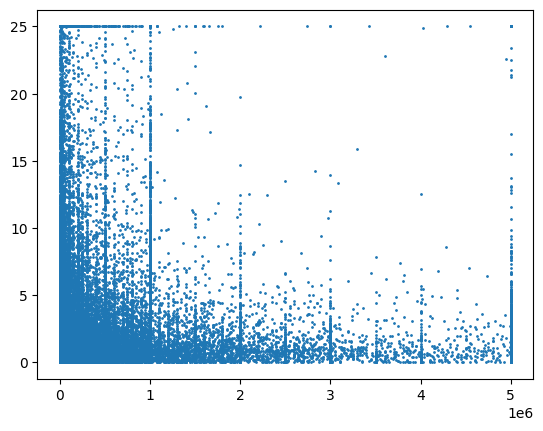

In [244]:
plt.scatter(df_trade_last[df_trade_last['trade_type'] == 'dealer_dealer']['quantity'], 
            np.clip(abs(df_trade_last[df_trade_last['trade_type'] == 'dealer_dealer']['target_oas'] - df_trade_last[df_trade_last['trade_type'] == 'dealer_dealer']['oas']), 0, 25), 
            s = 1)

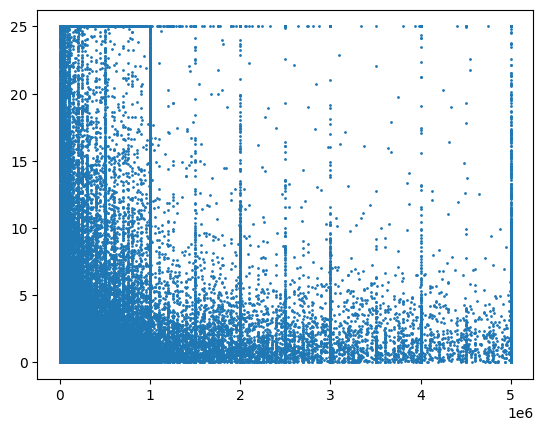

In [238]:
plt.scatter(df_trade_last[df_trade_last['trade_type'] != 'dealer_dealer']['quantity'], 
            np.clip(abs(df_trade_last[df_trade_last['trade_type'] != 'dealer_dealer']['target_oas'] - df_trade_last[df_trade_last['trade_type'] != 'dealer_dealer']['oas']), 0, 25), 
            s = 1)

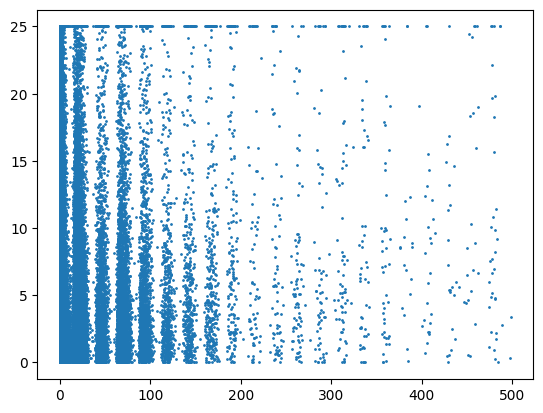

In [32]:
plt.scatter(df_trade_last[df_trade_last['ts_diff_hrs'] < 500]['ts_diff_hrs'], 
            np.clip(abs(df_trade_last[df_trade_last['ts_diff_hrs'] < 500]['target_oas'] - df_trade_last[df_trade_last['ts_diff_hrs'] < 500]['oas']), 0, 25), 
            s = 1)

In [242]:
df_trade_last['quantity'].describe(percentiles = [0.01, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95])

count    1.561860e+05
mean     6.751289e+05
std      1.226079e+06
min      1.310000e+02
1%       2.000000e+03
5%       4.000000e+03
15%      1.000000e+04
30%      3.500000e+04
50%      1.500000e+05
70%      5.000000e+05
85%      1.000000e+06
95%      5.000000e+06
max      5.000000e+06
Name: quantity, dtype: float64

In [393]:
# labels = [10000, 100000, 1000000, 2500000, 5000001]
# bins = [0, 10000, 100000, 1000000, 2500000, 5000001]

# df_trade_last['quantity_bin'] = pd.cut(df_trade_last['quantity'], bins=bins, labels=labels, right=False)

df_trade_last['quantity_bin'] = pd.qcut(df_trade_last['quantity'], q=5)


In [394]:
df_trade_last.groupby(['trade_type', 'quantity_bin'])['error'].describe(percentiles = [0.01, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95])

count      mean       std  min  \
trade_type    quantity_bin                                               
dealer_buy    (130.999, 16000.0]       9729.0  3.919193  5.535201  0.0   
              (16000.0, 75000.0]       8001.0  4.203909  5.788367  0.0   
              (75000.0, 258000.0]      8639.0  3.666947  5.098369  0.0   
              (258000.0, 1000000.0]   13106.0  4.333191  5.710981  0.0   
              (1000000.0, 5000000.0]   7343.0  2.317762  3.255182  0.0   
dealer_dealer (130.999, 16000.0]      10357.0  3.764830  5.077570  0.0   
              (16000.0, 75000.0]      10421.0  3.408884  4.815113  0.0   
              (75000.0, 258000.0]     10082.0  2.909173  4.340245  0.0   
              (258000.0, 1000000.0]   12251.0  2.811970  4.291844  0.0   
              (1000000.0, 5000000.0]   5577.0  1.678783  2.727113  0.0   
dealer_sell   (130.999, 16000.0]      11253.0  5.798051  7.557044  0.0   
              (16000.0, 75000.0]      13440.0  6.150461  7.882872  0.0   
              (75000.0, 258000.0]     11808.0  4.474593  6.270020  0.0   
              (258000.0, 1000000.0]   15585.0  4.614492  6.213642  0.0   
              (1000000.0, 5000000.0]   8594.0  2.912252  4.586978  0.0   

                                            1%        5%       15%      30%  \
trade_type    quantity_bin                                                    
dealer_buy    (130.999, 16000.0]      0.026540  0.147480  0.471720  1.00224   
              (16000.0, 75000.0]      0.037300  0.178100  0.520500  1.05670   
              (75000.0, 258000.0]     0.027838  0.142020  0.456080  0.99124   
              (258000.0, 1000000.0]   0.000000  0.129250  0.464375  1.05295   
              (1000000.0, 5000000.0]  0.000000  0.094900  0.334300  0.74450   
dealer_dealer (130.999, 16000.0]      0.000000  0.142600  0.500860  1.08212   
              (16000.0, 75000.0]      0.000000  0.101800  0.418600  0.92080   
              (75000.0, 258000.0]     0.000000  0.090105  0.351430  0.78760   
              (258000.0, 1000000.0]   0.000000  0.071950  0.333200  0.74130   
              (1000000.0, 5000000.0]  0.000000  0.036000  0.256040  0.53688   
dealer_sell   (130.999, 16000.0]      0.009000  0.171860  0.583640  1.27366   
              (16000.0, 75000.0]      0.005756  0.155780  0.567910  1.20897   
              (75000.0, 258000.0]     0.009314  0.138535  0.473510  1.00732   
              (258000.0, 1000000.0]   0.000000  0.070420  0.400620  1.00144   
              (1000000.0, 5000000.0]  0.000000  0.080545  0.340795  0.74575   

                                          50%      70%       85%        95%  \
trade_type    quantity_bin                                                    
dealer_buy    (130.999, 16000.0]      1.92930  3.53306   6.76264  18.325220   
              (16000.0, 75000.0]      2.03320  3.79320   7.46000  19.406500   
              (75000.0, 258000.0]     1.87570  3.38960   6.43818  14.935760   
              (258000.0, 1000000.0]   2.13750  4.24770   8.28590  18.429125   
              (1000000.0, 5000000.0]  1.38030  2.37462   3.86924   7.114220   
dealer_dealer (130.999, 16000.0]      2.02140  3.59064   6.54332  14.751240   
              (16000.0, 75000.0]      1.78660  3.22480   5.84790  13.193400   
              (75000.0, 258000.0]     1.49285  2.68957   4.83367  11.044175   
              (258000.0, 1000000.0]   1.40950  2.53900   4.63935  10.867900   
              (1000000.0, 5000000.0]  0.91990  1.60200   2.74904   5.167120   
dealer_sell   (130.999, 16000.0]      2.47990  5.00536  13.62868  25.000000   
              (16000.0, 75000.0]      2.46300  5.46586  15.99740  25.000000   
              (75000.0, 258000.0]     1.97190  3.90068   8.47852  24.173590   
              (258000.0, 1000000.0]   2.11310  4.37834   9.22276  22.416060   
              (1000000.0, 5000000.0]  1.43580  2.54781   4.61336  11.180510   

                                       max  
trade_type    quantity_bin                  
dea

In [41]:
df_trade_last['target_oas'].describe()

count    156186.000000
mean        165.237651
std         164.479705
min        -997.250800
25%          96.531325
50%         142.695050
75%         192.911300
max        4422.677200
Name: target_oas, dtype: float64

Check trade stuff

In [297]:
df_test.shape[0]

156186

In [298]:
temp_2_match = df_test[df_test['ts_diff_hrs_24'] == df_test['ts_diff_hrs_23']]
temp_2_match.shape[0]

59007

In [299]:
temp_3_match = df_test[df_test['ts_diff_hrs_24'] == df_test['ts_diff_hrs_22']]
temp_3_match.shape[0]

14016

In [300]:
temp_4_match = df_test[df_test['ts_diff_hrs_24'] == df_test['ts_diff_hrs_21']]
temp_4_match.shape[0]

3992

In [306]:
(temp_2_match['quantity_24'] - temp_2_match['quantity_23']).describe(percentiles = [0.01, 0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95, 0.99])

count    5.900700e+04
mean     4.976927e+03
std      2.527794e+05
min     -4.995000e+06
1%      -2.089400e+05
5%       0.000000e+00
15%      0.000000e+00
30%      0.000000e+00
50%      0.000000e+00
70%      0.000000e+00
85%      0.000000e+00
95%      0.000000e+00
99%      4.587600e+05
max      4.985000e+06
dtype: float64

# Modeling

## First, remove outliers from train set -> defined as abs(target_oas - last_oas) >= 25.

In [325]:
df_cleaned = df[abs(df['oas_24'] - df['target_oas']) <= 25]

## Data with no combos for last trade

In [429]:
df_no_combos = df_cleaned[df_cleaned['ts_diff_hrs_24'] != df_cleaned['ts_diff_hrs_23']]

# Determine what offset between buys/sells should be based off when last trade is buy/sell

In [430]:
df_no_combos['last_error'] = np.clip(abs(df_no_combos['oas_24'] - df_no_combos['target_oas']), 0, 25)
df_no_combos['last_bias'] = np.clip((df_no_combos['oas_24'] - df_no_combos['target_oas']), -25, 25)


/var/folders/qc/2g35_ptn6991_yxjy3j2n03h0000gn/T/ipykernel_14471/1591589512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_combos['last_error'] = np.clip(abs(df_no_combos['oas_24'] - df_no_combos['target_oas']), 0, 25)
/var/folders/qc/2g35_ptn6991_yxjy3j2n03h0000gn/T/ipykernel_14471/1591589512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_combos['last_bias'] = np.clip((df_no_combos['oas_24'] - df_no_combos['target_oas']), -25, 25)


In [431]:
df_no_combos.groupby('trade_type_24')['last_error'].mean()

trade_type_24
dealer_buy       3.109210
dealer_dealer    2.388495
dealer_sell      3.451958
Name: last_error, dtype: float64

In [432]:
df_no_combos.groupby('trade_type_24')['quantity_24'].describe()

,count,mean,std,min,25%,50%,75%,max
trade_type_24,,,,,,,,
dealer_buy,35112.0,878672.232255,1.432440e+06,1000.0,30000.0,205000.0,1000000.0,5000000.0
dealer_dealer,11107.0,825536.633546,1.240632e+06,1000.0,40000.0,250000.0,1000000.0,5000000.0
dealer_sell,43617.0,779010.887365,1.316725e+06,1000.0,34000.0,200000.0,1000000.0,5000000.0


In [433]:
offsets = df_no_combos.groupby('trade_type_24')['last_bias'].mean().to_dict()

In [589]:
offsets

{'dealer_buy': 1.3436733111187058,
 'dealer_dealer': -0.3395435581165028,
 'dealer_sell': -1.8331628080794187}

In [434]:
# offsets = {
#     'dealer_buy': -1.25,
#     'dealer_sell': 1.25,
#     'dealer_dealer': 0.25
# }

trade_weights = {
    'dealer_dealer': 1,
    'dealer_buy': .65,
    'dealer_sell': .65,
}


In [435]:
df_no_combos['adj_error'] = np.clip(abs(df_no_combos['oas_24'] + df_no_combos['trade_type_24'].map(offsets) - df_no_combos['target_oas']), 0, 25)
df_no_combos['adj_bias'] = np.clip((df_no_combos['oas_24'] + df_no_combos['trade_type_24'].map(offsets) - df_no_combos['target_oas']), -25, 25)


/var/folders/qc/2g35_ptn6991_yxjy3j2n03h0000gn/T/ipykernel_14471/3367052049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_combos['adj_error'] = np.clip(abs(df_no_combos['oas_24'] + df_no_combos['trade_type_24'].map(offsets) - df_no_combos['target_oas']), 0, 25)
/var/folders/qc/2g35_ptn6991_yxjy3j2n03h0000gn/T/ipykernel_14471/3367052049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_combos['adj_bias'] = np.clip((df_no_combos['oas_24'] + df_no_combos['trade_type_24'].map(offsets) - df_n

In [436]:
df_no_combos.groupby('trade_type_24')['adj_error'].mean()

trade_type_24
dealer_buy       3.759932
dealer_dealer    2.466637
dealer_sell      4.526044
Name: adj_error, dtype: float64

In [437]:
df_no_combos.groupby('trade_type_24')['adj_bias'].mean()

trade_type_24
dealer_buy       2.686343
dealer_dealer   -0.679060
dealer_sell     -3.661920
Name: adj_bias, dtype: float64

## Check some sizing stuff

In [439]:
quantity_cols = [col for col in df_no_combos.columns if 'quantity' in col]

In [443]:
df_no_combos['quantity_bin'] = pd.qcut(df_no_combos['quantity_24'], q=10)
df_no_combos.groupby(['trade_type_24', 'quantity_bin'])['adj_error'].describe()

/var/folders/qc/2g35_ptn6991_yxjy3j2n03h0000gn/T/ipykernel_14471/2255166036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_combos['quantity_bin'] = pd.qcut(df_no_combos['quantity_24'], q=10)


count      mean       std       min  \
trade_type_24 quantity_bin                                                   
dealer_buy    (999.999, 10000.0]      5236.0  3.649555  3.872143  0.000273   
              (10000.0, 24000.0]      2364.0  3.658194  3.872644  0.000827   
              (24000.0, 50000.0]      3383.0  3.941495  4.280327  0.001073   
              (50000.0, 100000.0]     3287.0  3.856034  4.219459  0.001327   
              (100000.0, 200000.0]    3247.0  3.646465  3.825522  0.001973   
              (200000.0, 433000.0]    3363.0  3.675185  3.895353  0.000873   
              (433000.0, 900000.0]    3377.0  3.771165  3.937734  0.006673   
              (900000.0, 1000000.0]   4627.0  5.115468  5.005163  0.006173   
              (1000000.0, 2750000.0]  2245.0  2.841702  2.705784  0.000927   
              (2750000.0, 5000000.0]  3983.0  2.829272  2.472349  0.001473   
dealer_dealer (999.999, 10000.0]      1242.0  2.918703  3.373993  0.001956   
              (10000.0, 24000.0]       785.0  2.808468  3.110911  0.016544   
              (24000.0, 50000.0]      1356.0  2.819401  3.218431  0.000456   
              (50000.0, 100000.0]      856.0  2.487087  3.351276  0.004844   
              (100000.0, 200000.0]     905.0  2.428447  3.104846  0.001544   
              (200000.0, 433000.0]     871.0  2.372278  3.110673  0.008856   
              (433000.0, 900000.0]    1265.0  2.804363  3.790544  0.001844   
              (900000.0, 1000000.0]   1730.0  2.683433  3.505695  0.002744   
              (1000000.0, 2750000.0]  1140.0  1.593006  2.273575  0.000144   
              (2750000.0, 5000000.0]   957.0  1.405774  2.159212  0.001456   
dealer_sell   (999.999, 10000.0]      5212.0  4.962441  4.900939  0.004337   
              (10000.0, 24000.0]      3284.0  5.119376  5.424151  0.006237   
              (24000.0, 50000.0]      5318.0  5.189810  5.363028  0.000337   
              (50000.0, 100000.0]     4510.0  4.542676  4.660264  0.002063   
              (100000.0, 200000.0]    4347.0  4.253400  4.266392  0.001237   
              (200000.0, 433000.0]    4336.0  4.135260  4.132482  0.006163   
              (433000.0, 900000.0]    4544.0  4.267907  4.310701  0.001963   
              (900000.0, 1000000.0]   5072.0  5.260775  4.844328  0.001837   
              (1000000.0, 2750000.0]  2961.0  3.687720  3.513948  0.000437   
              (2750000.0, 5000000.0]  4033.0  3.281416  2.885521  0.002863   

                                           25%       50%       75%        max  
trade_type_24 quantity_bin                                                     
dealer_buy    (999.999, 10000.0]      1.342598  2.512623  4.462612  25.000000  
              (10000.0, 24000.0]      1.286238  2.522600  4.277012  25.000000  
              (24000.0, 50000.0]      1.229273  2.560073  4.867000  25.000000  
              (50000.0, 100000.0]     1.217173  2.480673  4.712523  25.000000  
              (100000.0, 200000.0]    1.215773  2.508373  4.513123  25.000000  
              (200000.0, 433000.0]    1.215923  2.457973  4.542250  25.000000  
              (433000.0, 900000.0]    1.330973  2.484173  4.712573  25.000000  
              (900000.0, 1000000.0]   1.638150  3.352473  6.721073  25.000000  
              (1000000.0, 2750000.0]  1.171427  2.161373  3.655073  24.817673  
              (2750000.0, 5000000.0]  1.293150  2.282873  3.658673  24.223173  
dealer_dealer (999.999, 10000.0]      0.899378  1.843644  3.590994  24.179244  
              (10000.0, 24000.0]      0.800744  1.894644  3.489556  23.009544  
              (24000.0, 50000.0]      0.783622  1.818144  3.530072  24.820844  
              (50000.0, 100000.0]     0.516706  1.484444  2.991731  24.676244  
              (100000.0, 200000.0]    0.581544  1.461144  2.910656  24.510944  
              (200000.0, 433000.0]    0.498794  1.355544  2.858244  22.661256  
              (433000.0, 900000.0]    0.658256  1.475444  3.276356  25.000000  
              (900000.

In [446]:
temp_large = df_no_combos[df_no_combos['quantity_24'] > 1000000]

In [448]:
# temp_large['quantity_bin'] = pd.qcut(temp_large['quantity_24'], q=10, duplicates = 'drop')
# temp_large.groupby(['trade_type_24', 'quantity_bin'])['adj_error'].describe()

In [457]:
df_no_combos['quantity_cutoff'] = np.where(df_no_combos['quantity_24'] > 1000000, 'large', 'small')

/var/folders/qc/2g35_ptn6991_yxjy3j2n03h0000gn/T/ipykernel_14471/3266329403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_combos['quantity_cutoff'] = np.where(df_no_combos['quantity_24'] > 1000000, 'large', 'small')


In [456]:
df_no_combos.groupby(['trade_type_24', 'quantity_cutoff'])['adj_error'].describe()

count      mean       std       min  \
trade_type_24 quantity_cutoff                                          
dealer_buy    0                28884.0  3.959636  4.197116  0.000273   
              1                 6228.0  2.833753  2.558741  0.000927   
dealer_dealer 0                 9010.0  2.689854  3.368064  0.000456   
              1                 2097.0  1.507560  2.223546  0.000144   
dealer_sell   0                36623.0  4.730885  4.778277  0.000337   
              1                 6994.0  3.453430  3.172950  0.000437   

                                    25%       50%       75%        max  
trade_type_24 quantity_cutoff                                           
dealer_buy    0                1.332398  2.606100  4.881798  25.000000  
              1                1.247073  2.243773  3.658673  24.817673  
dealer_dealer 0                0.674769  1.603644  3.240744  25.000000  
              1                0.459956  0.961844  1.659044  24.563156  
dealer_sell   0                1.833163  3.149463  5.655063  25.000000  
              1                1.641031  2.673513  4.179988  25.000000

In [459]:
weights_size = {
    'large': 1,
    'small': .65,
}

## Data w combos

In [465]:
temp = df_cleaned[df_cleaned['ts_diff_hrs_24'] == df_cleaned['ts_diff_hrs_23']]
temp = temp[temp['quantity_23'] == temp['quantity_24']]

In [466]:
temp['mid'] = (temp['oas_24'] + temp['oas_23'])/ 2

temp['mid_error'] = np.clip(abs(temp['mid'] - temp['target_oas']), 0, 25)
temp['last_error'] = np.clip(abs(temp['oas_24'] - temp['target_oas']), 0, 25)

In [467]:
temp.groupby(['trade_type_23', 'trade_type_24'])['mid_error', 'last_error'].describe()

# Want logic such that if theres a buy/sell -> take midpoint for logical purposes, if theres a dealer trade involved just take the dealer pricing, if buy/buy or sell/sell, can just do normal. 

/var/folders/qc/2g35_ptn6991_yxjy3j2n03h0000gn/T/ipykernel_14471/3942767302.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp.groupby(['trade_type_23', 'trade_type_24'])['mid_error', 'last_error'].describe()


mid_error                                     \
                                count      mean       std  min       25%   
trade_type_23 trade_type_24                                                
dealer_buy    dealer_buy        335.0  2.611857  3.533701  0.0  0.591100   
              dealer_dealer    7906.0  3.382101  4.267771  0.0  0.791700   
              dealer_sell      1330.0  2.645698  3.250309  0.0  0.662625   
dealer_dealer dealer_buy       7326.0  3.119110  3.637878  0.0  0.801600   
              dealer_dealer   16052.0  2.557698  3.294314  0.0  0.616375   
              dealer_sell      8640.0  3.527637  3.916908  0.0  0.881225   
dealer_sell   dealer_buy       1282.0  2.665543  3.259574  0.0  0.655275   
              dealer_dealer    9602.0  5.018943  6.139576  0.0  1.014213   
              dealer_sell       513.0  3.236461  4.622629  0.0  0.739000   

                                                         last_error            \
                                  50%       75%      max      count      mean   
trade_type_23 trade_type_24                                                     
dealer_buy    dealer_buy     1.451400  2.880600  23.4374      335.0  2.639912   
              dealer_dealer  1.869350  4.032425  25.0000     7906.0  2.894722   
              dealer_sell    1.553175  3.272437  25.0000     1330.0  2.758773   
dealer_dealer dealer_buy     1.889250  3.921663  25.0000     7326.0  3.500462   
              dealer_dealer  1.461325  3.100725  25.0000    16052.0  2.566571   
              dealer_sell    2.115050  4.694187  25.0000     8640.0  4.404656   
dealer_sell   dealer_buy     1.607300  3.347475  25.0000     1282.0  2.602422   
              dealer_dealer  2.477400  6.275200  25.0000     9602.0  2.918435   
              dealer_sell    1.578300  3.499700  25.0000      513.0  3.160323   

                                                                         \
                                  std  min       25%      50%       75%   
trade_type_23 trade_type_24                                               
dealer_buy    dealer_buy     3.557686  0.0  0.640050  1.45740  2.911050   
              dealer_dealer  3.605442  0.0  0.724275  1.66565  3.513025   
              dealer_sell    3.433945  0.0  0.703100  1.63095  3.349450   
dealer_dealer dealer_buy     4.203531  0.0  0.842475  2.00490  4.396025   
              dealer_dealer  3.280641  0.0  0.630275  1.48010  3.131875   
              dealer_sell    5.326416  0.0  0.945600  2.35095  5.410850   
dealer_sell   dealer_buy     3.167571  0.0  0.692500  1.59755  3.261600   
              dealer_dealer  3.588058  0.0  0.719425  1.73830  3.591425   
              dealer_sell    4.415985  0.0  0.735100  1.58820  3.464100   

                                      
                                 max  
trade_type_23 trade_type_24           
dealer_buy    dealer_buy     23.4374  
              dealer_dealer  24.9996  
              dealer_sell    24.7559  
dealer_dealer dealer_buy     24.9374  
              dealer_dealer  24.8520  
              dealer_sell    24.9833  
dealer_sell   dealer_buy     24.0883  
              dealer_dealer  24.9490  
              dealer_sell    24.7994

## First, remove outliers from train set -> defined as abs(target_oas - last_oas) >= 25.

In [556]:
def data_model_format_retry(dataset: List[Dict]) -> List[Dict]:

    ret_data = []
    
    for i in tqdm(range(len(dataset))):
        observation = dataset[i]
        prev_trades = observation["prev_trades"]
        if len(prev_trades) == 0:
            continue

        row_data = {}
        row_data['target_oas'] = observation['oas']

        obs_oas = []
        trade_type = []
        quantities = []
        times = []

        last_ts = 0
        last_quantity = 0
        last_type = ''
        curr_dealer_oas = []
        curr_cust_oas = []
 
        for ix, row in prev_trades.reset_index().iloc[::-1].iterrows():

            if last_ts != row['ts_diff_hrs'] or last_quantity != row['quantity']:
                if curr_dealer_oas and curr_cust_oas:
                    obs_oas.append(np.mean(curr_dealer_oas))
                    trade_type.append('combo_dc')

                elif len(curr_cust_oas) >= 2:
                    obs_oas.append(np.mean(curr_cust_oas))
                    trade_type.append('combo_cc')  

                elif len(curr_dealer_oas) >= 2:
                    obs_oas.append(np.mean(curr_dealer_oas))
                    trade_type.append('combo_dd')

                elif curr_dealer_oas:
                    obs_oas.append(np.mean(curr_dealer_oas))
                    trade_type.append('dealer_dealer')      

                elif curr_cust_oas:
                    obs_oas.append(np.mean(curr_cust_oas))
                    trade_type.append(last_type)                    
              
                if curr_dealer_oas or curr_cust_oas:
                    quantities.append(last_quantity)
                    times.append(last_ts)
                    curr_dealer_oas = []
                    curr_cust_oas = []

            if row['trade_type'] != 'dealer_dealer':
                curr_cust_oas.append(row['oas'])
            else:
                curr_dealer_oas.append(row['oas'])        
                        
            last_ts = row['ts_diff_hrs']
            last_quantity = row['quantity'] 
            last_type = row['trade_type']               
        
        row_data['data_oas'] = obs_oas
        row_data['data_type'] = trade_type
        row_data['data_time'] = times
        row_data['data_quantity'] = quantities

        ret_data.append(row_data)
        
    return ret_data

In [639]:
def data_model_format_retry(dataset: List[Dict]) -> List[Dict]:

    ret_data = []
    
    for i in tqdm(range(len(dataset))):
        observation = dataset[i]
        prev_trades = observation["prev_trades"]
        if len(prev_trades) == 0:
            continue

        row_data = {}
        row_data['target_oas'] = observation['oas']

        obs_oas = []
        trade_type = []
        quantities = []
        times = []

        last_ts = 0
        last_quantity = 0
        last_type = ''
        curr_dealer_oas = []
        curr_cust_oas = []
 
        for ix, row in prev_trades.reset_index().iloc[::-1].iterrows():

            if last_ts != row['ts_diff_hrs'] or last_quantity != row['quantity']:
                if curr_dealer_oas and curr_cust_oas:
                    obs_oas.append(np.mean(curr_dealer_oas))
                    trade_type.append('combo_dc')

                elif len(curr_cust_oas) >= 2:
                    obs_oas.append(np.mean(curr_cust_oas))
                    trade_type.append('combo_cc')  

                elif len(curr_dealer_oas) >= 2:
                    obs_oas.append(np.mean(curr_dealer_oas))
                    trade_type.append('combo_dd')

                elif curr_dealer_oas:
                    obs_oas.append(np.mean(curr_dealer_oas))
                    trade_type.append('dealer_dealer')      

                elif curr_cust_oas:
                    obs_oas.append(np.mean(curr_cust_oas))
                    trade_type.append(last_type)                    
              
                if curr_dealer_oas or curr_cust_oas:
                    quantities.append(last_quantity)
                    times.append(last_ts)
                    curr_dealer_oas = []
                    curr_cust_oas = []

                    

            if row['trade_type'] != 'dealer_dealer':
                curr_cust_oas.append(row['oas'])
            else:
                curr_dealer_oas.append(row['oas'])        
                        
            last_ts = row['ts_diff_hrs']
            last_quantity = row['quantity'] 
            last_type = row['trade_type'] 

        
        if curr_dealer_oas and curr_cust_oas:
            obs_oas.append(np.mean(curr_dealer_oas))
            trade_type.append('combo_dc')

        elif len(curr_cust_oas) >= 2:
            obs_oas.append(np.mean(curr_cust_oas))
            trade_type.append('combo_cc')  

        elif len(curr_dealer_oas) >= 2:
            obs_oas.append(np.mean(curr_dealer_oas))
            trade_type.append('combo_dd')

        elif curr_dealer_oas:
            obs_oas.append(np.mean(curr_dealer_oas))
            trade_type.append('dealer_dealer')      

        elif curr_cust_oas:
            obs_oas.append(np.mean(curr_cust_oas))
            trade_type.append(last_type)                    
        
        if curr_dealer_oas or curr_cust_oas:
            quantities.append(last_quantity)
            times.append(last_ts)
            curr_dealer_oas = []
            curr_cust_oas = []

        row_data['data_oas'] = obs_oas
        row_data['data_type'] = trade_type
        row_data['data_time'] = times
        row_data['data_quantity'] = quantities

        ret_data.append(row_data)
        
    return ret_data

In [641]:
train_data_final_retry =  data_model_format_retry(train_dataset)

100%|██████████| 156186/156186 [01:43<00:00, 1512.10it/s]


In [642]:
df_data_final = pd.DataFrame(train_data_final_retry)

In [655]:
df_data_final['last_data_type'] = df_data_final['data_type'].apply(lambda x: x[0])
df_data_final['last_oas'] = df_data_final['data_oas'].apply(lambda x: x[0])

df_data_final['error_last'] = np.clip(abs(df_data_final['target_oas'] - df_data_final['last_oas']), 0, 25)
df_data_final['bias_last'] = np.clip(df_data_final['target_oas'] - df_data_final['last_oas'], -25, 25)

In [657]:
df_data_final[df_data_final['error_last'] < 25].groupby('last_data_type')[['error_last', 'bias_last']].describe()

error_last                                              \
                    count      mean       std  min       25%      50%   
last_data_type                                                          
combo_cc           3223.0  2.661684  3.396312  0.0  0.647025  1.53135   
combo_dc          37954.0  2.961151  3.643310  0.0  0.734775  1.75530   
combo_dd          13378.0  2.362928  3.119432  0.0  0.581237  1.33730   
dealer_buy        36483.0  3.139692  3.935642  0.0  0.759450  1.77020   
dealer_dealer     13866.0  2.322926  3.161767  0.0  0.562650  1.27810   
dealer_sell       46342.0  3.492120  4.488378  0.0  0.753725  1.83800   

                                   bias_last                                \
                     75%       max     count      mean       std       min   
last_data_type                                                               
combo_cc        3.219850  24.79940    3223.0  0.248717  4.308111 -23.62765   
combo_dc        3.642175  24.99960   37954.0  0.367837  4.680497 -24.98100   
combo_dd        2.813250  24.93345   13378.0  0.013132  3.913379 -24.93345   
dealer_buy      3.782600  24.97680   36483.0 -1.386773  4.839836 -24.96380   
dealer_dealer   2.741750  24.94660   13866.0  0.285076  3.913038 -24.90270   
dealer_sell     4.156975  24.99140   46342.0  1.891100  5.363242 -24.91880   

                                                       
                     25%       50%       75%      max  
last_data_type                                         
combo_cc       -1.314275  0.179600  1.709250  24.7994  
combo_dc       -1.398375  0.263000  2.081200  24.9996  
combo_dd       -1.294788  0.044575  1.373300  24.6295  
dealer_buy     -2.819100 -0.813600  0.682050  24.9768  
dealer_dealer  -0.978825  0.227050  1.554225  24.9466  
dealer_sell    -0.430325  0.983000  3.179975  24.9914

In [693]:
def fit_weighted_average(
    values: List[float], 
    weights: List[float], 
    half_life: float = 1
) -> float:
    
    if len(values) != len(weights):
        raise ValueError("The length of values and weights must be the same.")
    
    decay_factor = 0.5 ** (1 / half_life)
    exp_weights = [decay_factor ** i for i in range(len(values))]
    
    combined_weights = [w * ew for w, ew in zip(weights, exp_weights)]
    weighted_average = sum(v * cw for v, cw in zip(values, combined_weights)) / sum(combined_weights)
    
    return weighted_average

In [705]:
offsets = {'dealer_buy': 1.25,
 'dealer_dealer': -0.2,
 'dealer_sell': -1.45}

trade_weights = {
    'dealer_dealer': 1,
    'dealer_buy': .65,
    'dealer_sell': .65,
    'combo_dd': 1.1,
    'combo_dc': 0.9,
    'combo_cc': .75
}

def f_weight_quantity(i, cutoff = 1000000):
    if i > cutoff:
        return 1
    else:
        return 0.65
    
def f_offset_type(data_type: str):
    if data_type in offsets:
        return offsets[data_type]
    else:
        return 0
    
def f_weight_type(data_type: str):
    if data_type in trade_weights:
        return trade_weights[data_type]
    else:
        return 0    

In [706]:
def get_prediction(row, half_life):
    weights_size = np.array([f_weight_quantity(quantity) for quantity in row['data_quantity']])
    weights_type = np.array([f_weight_type(type) for type in row['data_type']])
    offset = np.array([f_offset_type(type) for type in row['data_type']])
    observations = np.array(row['data_oas'])

    return fit_weighted_average(values = offset + observations, weights = weights_size * weights_type, half_life = half_life)



In [707]:
df_data_final['prediction'] = df_data_final.apply(lambda row: get_prediction(row, 2), axis=1)

df_data_final['error_prediction'] = np.clip(abs(df_data_final['prediction'] - df_data_final['last_oas']), 0, 25)
df_data_final['bias_prediction'] = np.clip(df_data_final['prediction'] - df_data_final['last_oas'], -25, 25)

In [708]:
df_data_final[df_data_final['error_last'] < 25].groupby('last_data_type')[['error_prediction', 'bias_prediction']].describe()

error_prediction                                          \
                          count      mean       std       min       25%   
last_data_type                                                            
combo_cc                 3223.0  2.371239  3.774444  0.000000  0.499818   
combo_dc                37954.0  2.271397  3.335567  0.000000  0.531355   
combo_dd                13378.0  1.811814  2.871976  0.000000  0.434675   
dealer_buy              36483.0  2.552711  3.873681  0.000100  0.550241   
dealer_dealer           13866.0  2.321813  4.059069  0.000141  0.404390   
dealer_sell             46342.0  2.683181  3.921562  0.000040  0.571109   

                                         bias_prediction                      \
                     50%       75%   max           count      mean       std   
last_data_type                                                                 
combo_cc        1.151902  2.490730  25.0          3223.0 -0.155727  4.454963   
combo_dc        1.220342  2.563341  25.0         37954.0 -0.364648  4.019007   
combo_dd        0.981106  1.975639  25.0         13378.0 -0.071373  3.395006   
dealer_buy      1.260449  2.755633  25.0         36483.0 -0.904488  4.550142   
dealer_dealer   0.930770  2.238637  25.0         13866.0 -0.730693  4.618798   
dealer_sell     1.309795  2.926599  25.0         46342.0  0.889680  4.667624   

                                                          
                 min       25%       50%       75%   max  
last_data_type                                            
combo_cc       -25.0 -1.276245 -0.096771  1.003525  25.0  
combo_dc       -25.0 -1.451253 -0.186472  0.977896  25.0  
combo_dd       -25.0 -1.070707 -0.133061  0.861339  25.0  
dealer_buy     -25.0 -1.890109 -0.428705  0.693788  25.0  
dealer_dealer  -25.0 -1.341654 -0.352600  0.497284  25.0  
dealer_sell    -25.0 -0.985626  0.158183  1.830464  25.0

In [709]:
df_data_final[['error_prediction', 'error_last']].mean()

error_prediction    2.873122
error_last          3.743385
dtype: float64